# Graph metrics ratio for undowloaded channels

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sknetwork.data import convert_edge_list
from sknetwork.clustering import PropagationClustering
from langdetect import detect, detect_langs, lang_detect_exception
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings('ignore')

## 1. Data extraction

In [2]:
# I uploaded data into tsv

In [3]:
channels = pd.read_csv('channels.tsv', sep='\t')

In [4]:
channels.head()

,id,title
0,1082084045,Караульный
1,1289588056,Мастер пера
2,1428407219,Про_чтение
3,1310493808,Темы. Главное (ГлавМедиа)
4,1185353204,Экономика Беларуси


In [5]:
edges = pd.read_csv('2021_05_23_edges_all.tsv', sep='\t')

In [6]:
edges.head()

,1000006831,1001650098,1
0,1000006831,1003366652,2
1,1000006831,1003381040,1
2,1000006831,1003448364,1
3,1000006831,1003705962,1
4,1000006831,1004185333,1


## 2. Graph metrics

### 2.1 Degree and weighted degree

In [7]:
edge_list = list(edges.itertuples(index=False, name=None))

In [8]:
graph = nx.DiGraph()

In [9]:
graph.add_weighted_edges_from(edge_list)

also exist another way to read data in graph

In [10]:
# graph = nx.read_edgelist('2021_05_23_edges_all.tsv', create_using=nx.DiGraph, nodetype=int, data=(("weight", int),))

In [11]:
g_metrics = (pd.DataFrame(list(graph.degree), columns=['id', 'degree'])
 .merge(pd.DataFrame(list(graph.degree(weight='weight')), columns=['id', 'weight_degree']), on='id')
)

In [12]:
g_metrics.shape

(226229, 3)

### 2.2 Clusterisation

In [13]:
graph = convert_edge_list(edge_list, directed=True)

In [14]:
adjacency = graph.adjacency

In [15]:
propagation = PropagationClustering()
labels = propagation.fit_transform(adjacency)

In [16]:
g_metrics = g_metrics.merge(pd.DataFrame({'id': graph.names, 'cluster': labels}), on='id')

In [17]:
g_metrics.head()

,id,degree,weight_degree,cluster
0,1000006831,88,488,7466
1,1003366652,11,39,3963
2,1003381040,1,1,3983
3,1003448364,18,76,40468
4,1003705962,125,550,4705


## 3. Query rating computation and load

In [18]:
df = g_metrics.merge(channels, on='id', how='left')

In [19]:
df.head()

,id,degree,weight_degree,cluster,title
0,1000006831,88,488,7466,روزنامه وقايع استان
1,1003366652,11,39,3963,NaN
2,1003381040,1,1,3983,NaN
3,1003448364,18,76,40468,موسسه خیریه حامی یار
4,1003705962,125,550,4705,EsteghlalPage


In [20]:
df['title'].fillna('', inplace=True)

In [21]:
df_nan_cnt = df[df['title']!=''].groupby('cluster')['title'].count().reset_index().set_axis(['cluster', 'undwl_cnt'], axis='columns')

In [22]:
df_nan_cnt.head()

,cluster,undwl_cnt
0,4,1
1,23,1
2,99,1
3,165,1
4,181,1


### 3.1 Groupping 

In [23]:
df_g = (df.groupby(['cluster'])
 .agg({'cluster': 'count', 'id': lambda x: x.tolist(), 'title': lambda x: x.tolist()})
 .set_axis(['cnt', 'id_list', 'title_list'], axis='columns')
 .reset_index()
)

In [24]:
df_g.head()

,cluster,cnt,id_list,title_list
0,0,1,[1000000594],[]
1,1,1,[1000000881],[]
2,2,1,[1000000882],[]
3,3,1,[1000002589],[]
4,4,1,[1000002626],[Hyperadio]


In [25]:
df_g.shape

(179148, 4)

In [26]:
df_g['title_uniq_cnt'] = df_g['title_list'].apply(lambda x: len(set(x)))
df_g.sort_values(by='title_uniq_cnt', ascending=False, inplace=True)

In [27]:
df_g = df_g[df_g['cnt']>2]

In [28]:
df_g = df_g[df_g['title_uniq_cnt']>1]

In [29]:
df_g.shape

(3576, 5)

### 3.2 Language detection

In [30]:
def detect_with_except(x):
    try:
        return detect(', '.join(x))
    except lang_detect_exception.LangDetectException:
        return None

In [31]:
def detect_ru_with_except(x):
    try:
        lang = detect_langs(', '.join(x))
        for item in lang:
            if item.lang == 'ru':
                return item.prob
                break
        else:
            return None
    except lang_detect_exception.LangDetectException:
        return None

In [32]:
df_g['lang'] = df_g['title_list'].apply(detect_with_except)

In [33]:
df_g['lang_ru_prob'] = df_g['title_list'].apply(detect_ru_with_except)

In [34]:
df_g[['cluster', 'lang', 'lang_ru_prob']].head(10)

,cluster,lang,lang_ru_prob
42373,42373,ru,0.999997
8671,8671,ru,0.999997
15271,15271,ru,0.999998
43951,43951,ru,0.999997
13150,13150,ru,0.999996
12872,12872,ru,0.999996
63941,63941,ru,0.999996
15651,15651,ru,0.999998
52572,52572,ru,0.999998
46666,46666,ru,0.999998


[]

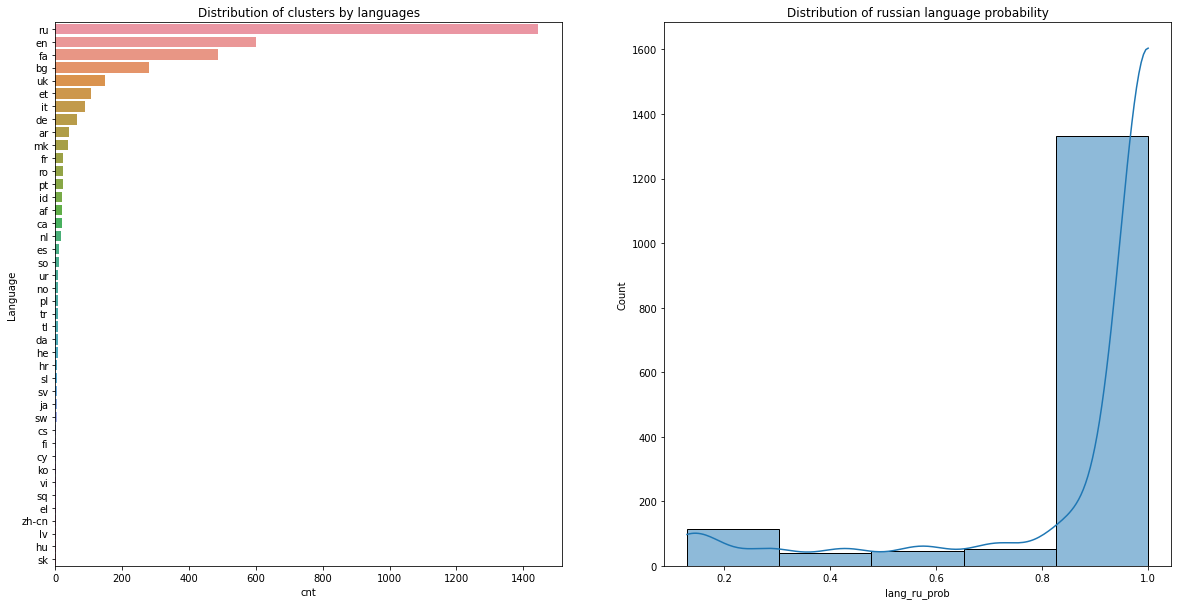

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
sns.barplot(x='cnt', y='Language', data=pd.DataFrame(df_g['lang'].value_counts()).reset_index().set_axis(['Language', 'cnt'], axis='columns'), ax=ax[0]
           ).set_title('Distribution of clusters by languages')
sns.histplot(x='lang_ru_prob', data=df_g[df_g['lang_ru_prob']>0], kde=True, bins=5, ax=ax[1]).set_title('Distribution of russian language probability')
plt.plot()

### 3.3 Recomendation computation

In [36]:
df_g = df_g.merge(df_nan_cnt, on='cluster')

In [37]:
df_g.head()

,cluster,cnt,id_list,title_list,title_uniq_cnt,lang,lang_ru_prob,undwl_cnt
0,42373,2354,"[1000098325, 1021645597, 1268589214, 107556575...","[Twitter лента @StalinGulag, Smm room, The Bel...",2350,ru,0.999997,2354
1,8671,1261,"[1000058135, 1025634770, 1237339329, 100015488...","[Republic, Сапрыкин - ст., Republic: Власть, B...",1261,ru,0.999997,1261
2,15271,1122,"[1003613922, 1037756687, 1027423644, 110280146...","[ _IranApple_ , IT и СОРМ, Анонимный канал Д...",1121,ru,0.999998,1122
3,43951,1026,"[1006548020, 1075088144, 1073531022, 119010589...","[Шапито, Генеральная прокуратура Российской Фе...",1026,ru,0.999997,1026
4,13150,944,"[1408035371, 1318480909, 1071365669, 111871028...","[VTimes, Стоунер, Павел Чиков, Компромат 2.0 :...",944,ru,0.999996,943


In [38]:
df_g[df_g['lang_ru_prob']>0]['undwl_cnt'].sum()

31278

So, we need to uploaded more than 31K channels with russian language

In [39]:
df_rec = df[(df['title']=='') & (df['cluster'].isin(df_g[(df_g['lang']=='ru') | (df_g['lang']=='bg')]['cluster'].tolist()))]

In [40]:
df_rec['degree_n'] = StandardScaler().fit_transform(df_rec[['degree']])
df_rec['weight_degree_n'] = StandardScaler().fit_transform(df_rec[['weight_degree']])

In [41]:
df_rec['w2d'] = (2 * df_rec['degree_n'] * df_rec['weight_degree_n']) / (df_rec['degree_n'] + df_rec['weight_degree_n'])

In [42]:
df_rec.sort_values(by='w2d', ascending=False, inplace=True)

In [43]:
df_rec[['id', 'w2d']].reset_index(drop=True).head(50)

,id,w2d
0,1059135528,12.072728
1,1096478352,10.829633
2,1272848778,8.860427
3,1259294143,6.554116
4,1141538691,6.395265
5,1255295153,6.279896
6,1308427268,5.825977
7,1088675969,5.130661
8,1293718310,4.659788
9,1119093282,4.587585
